# Tarea 3. Concurso CartoonImageNet
## Arnoldo Fernando Chue Sánchez

**Indicaciones**

Haz clasificación en este dataset, usando:
- Un modelo manual (e.g. NO preentrenado)
- Máximo 10M de parámetros
- Máximo entrena 12 épocas.
- Máximo tamaño de imagen: 256x256
- Cada época debe tardar máximo 2 minutos en mi computadora. ¿No sabes qué tan buena es mi compu? No te arriesgues!


Recordemos que el dataset es una versión cartoonizada y reducida de Imagenet

In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import prod, sqrt, log, exp
from pathlib import Path

Comenzemos con la función para armar los DataBlocks porque tenemos los folders de las imágenes bien organizados desde el inicio

In [2]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(max_rotate=30, # vamos a rotar ligeramente las imagenes (si tenemos bajo ajuste igual le bajamos si se nos pasó la mano)
                             max_lighting=0.25,
                             max_zoom=1.2,
                             max_warp=0.2
                             )
    
    data = fv.DataBlock(blocks = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y = fv.parent_label,
                        splitter = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms = tfms,
                        )
    
    return data.dataloaders(folder, batch_size=batch_size)

Ahora vamos a construir algunos bloques y funciones que nos pueden servir para los diferentes experimentos

En primer lugar hay que tener la función que calcula el número de parámetros por las limitaciones en los diseños de las arquitecturas

In [3]:
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

Vamos a usar las funciones hechas para convoluciones que vimos en clase

In [4]:
def create_identity_conv_weight(ni, no=None, k=3, s=1, device='cpu'):
    if no is None: no = ni
    noo = no if no >= ni else ni
    T = torch.zeros(noo, ni, k, k, device=device)
    I = torch.arange(ni, device=device)
    a = (k - s)//2
    b = a + s
    T[I, I, a:b, a:b] = 1/s**2
    return T[:no]

def init_conv_weight(w, nc, g, s):
    no, ni, k, k, = w.shape
    no //= g
    with torch.no_grad():
        for i in range(g):
            c = min(ni, nc, no)
            start = i*no
            end = start + c
            w[start:end] = create_identity_conv_weight(ni, c, k, s, w.device)
            nc -= c
            if nc <= 0: break

def init_id_conv(conv, wd=1., nc=None):
    conv.init_id = True
    conv.wd = wd

    no, ni, k, k = conv.weight.shape
    g = conv.groups
    s = conv.stride[0]

    if nc is None: nc = min(no, ni*g)
    assert(0 < nc <= min(no, ni*g))
    conv.nc = nc

    if conv.bias is not None: nn.init.constant_(conv.bias, 0.)

    init_conv_weight(conv.weight, nc, g, s)


def identity(x): return x

def conv2d(ni, no, k=3, s=1, pad="same", g=1, init='none', bias=True, nc=None):
    if pad == "same": pad = (k-1)//2

    conv = nn.Conv2d(ni, no, kernel_size=k, stride=s, padding=pad, groups=g, bias=bias)

    if bias: nn.init.constant_(conv.bias, 0.)

    if not fv.is_listy(init): init = [init]

    if 'linear' in init: nn.init.kaiming_normal_(conv.weight, nonlinearity=init)
    else: nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')

    if 'id' in init or 'avg' in init: init_id_conv(conv, nc=nc)
    
    return conv

Con esto ya casi tenemos todo para nuestra primera arquitectura. Voy a usar la combinación de capas: batch_norm, conv2d y función de activación (vamos a usar relu)

Así que vamos a preparar este código porque no está en nuestro módulo Layers de la clase

In [5]:
import inspect

def delegates(to=None, keep=False):
    def _f(f):
        if to is None: to_f, from_f = f.__base__.__init__, f.__init__
        else: to_f, from_f = to, f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v for k, v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        from_f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

relu = nn.ReLU(inplace=False)
default_act = relu

def init_bn_to_0(bn, wd=1.):
    nn.init.constant_(bn.weight, 0.)
    bn.init_zero = True
    bn.wd = wd

@delegates(conv2d)
def bca(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p=0., init='relu', **kwargs):
    layers = []

    if bn:
        layers += [nn.BatchNorm2d(ni)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    layers += [conv2d(ni, no, bias=(not bn), **kwargs)]

    if activation: layers += [act_fn]

    if p > 0: layers += [nn.Dropout2d(p)]

    return layers

Ahora sí, vamos a realizar el primer modelo con una arquitectura propia

In [6]:
data = load_data("CartoonImagenette", 256, 64) 

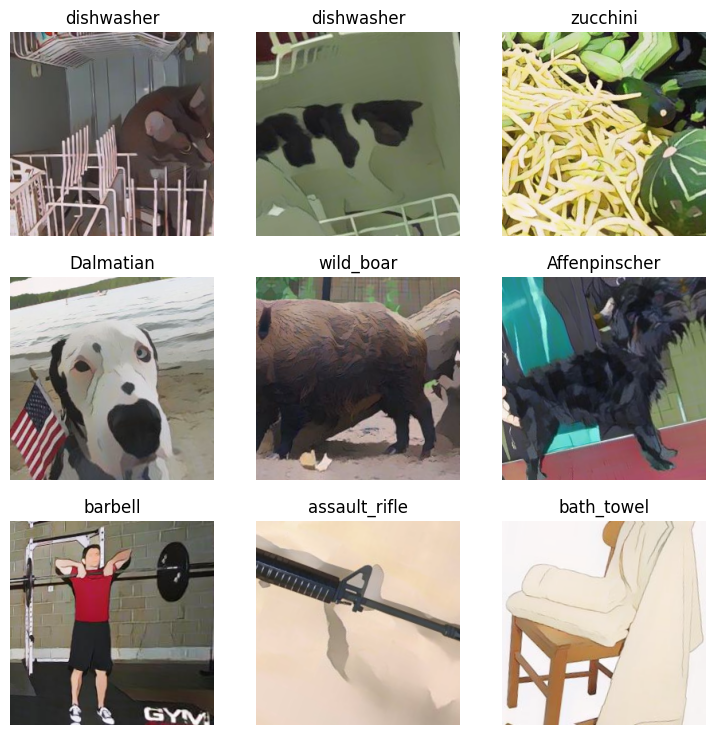

In [7]:
data.show_batch()

In [9]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

Un detalle antes: así como tenemos nuestro bloque bca, hay que hacer uno equivalente para la parte densa de la red. Sin embargo, el orden será: capa linea, activación y batch_norm

In [7]:
leaky_i = nn.LeakyReLU(1/16, inplace=True)

def lab(ni, no, bn=True, activation=True, act_fn=leaky_i, bn_init_zero=False, p=0.):
    layers = []

    layers += [nn.Linear(ni, no)]

    if activation: layers += [act_fn]

    if p > 0: layers += [nn.Dropout(p)]

    if bn:
        layers += [nn.BatchNorm1d(no)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    return layers

In [9]:
model1 = nn.Sequential(
    *bca(3,16,k=2,s=2),
    *bca(16,32),
    *bca(32,64,k=2,s=2),
    *bca(64,64),
    *bca(64,64,k=2,s=2),
    *bca(64,64),
    *bca(64,64,k=2,s=2),
    *bca(64,64),
    *bca(64,64,k=2,s=2),
    *bca(64,64),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(64, data.c)
)

In [12]:
num_params(model1)

212474

Por ahora comenzamos con pocos parámetros. Nos quedan tan pocos por el AdaptiveAvgPool2d. Esta capa la quise poner porque si no nos quedaban tensores demasiado grandes, que en la capa densa harían que nos quedaran en total más de los parámetros permitidos

In [13]:
learn1 = fv.Learner(data, 
                   model1, 
                   opt_func=fv.ranger, 
                   metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.013182567432522774)

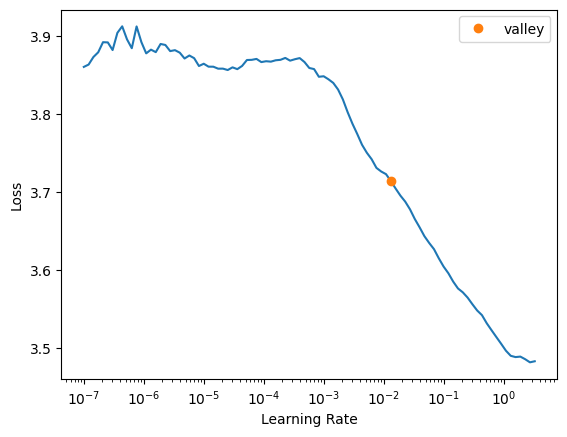

In [14]:
learn1.lr_find()

In [15]:
learn1.fit_one_cycle(12, 0.02, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.609080,2.617313,0.195000,00:31
1,2.221704,2.379112,0.283571,00:31
2,2.001626,2.194971,0.344286,00:30
3,1.851444,2.190293,0.342143,00:31
4,1.780663,2.212999,0.348571,00:31
5,1.694807,2.238998,0.373571,00:30
6,1.666701,1.778648,0.452143,00:31
7,1.602295,1.874393,0.435714,00:30
8,1.540485,1.885195,0.443571,00:30
9,1.423432,1.476890,0.505714,00:30


Llegamos a 56% de accuracy en 12 épocas para este primer modelo. Preparemos una arquitectura con más convoluciones con estos mismos bloques

In [16]:
model2 = nn.Sequential(
    *bca(3,64,k=2,s=2),
    *bca(64,128),
    *bca(128,256,k=2,s=2),
    *bca(256,256),
    *bca(256,256,k=2,s=2),
    *bca(256,256),
    *bca(256,256,k=2,s=2),
    *bca(256,256),
    *bca(256,256,k=2,s=2),
    *bca(256,256),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(256, data.c)
)

In [17]:
num_params(model2)

3362522

Con esto apenas ya tenemos un mayor número de parámetros

In [18]:
learn2 = fv.Learner(data, 
                   model2, 
                   opt_func=fv.ranger, 
                   metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.007585775572806597)

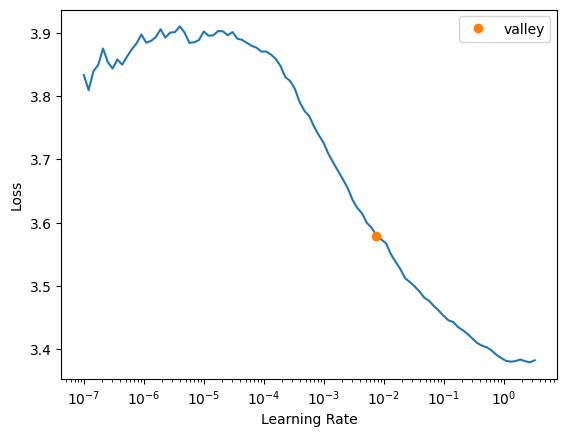

In [19]:
learn2.lr_find()

In [20]:
learn2.fit_one_cycle(12, 0.001, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.489381,2.512861,0.271429,00:59
1,2.120718,2.028322,0.405714,01:00
2,1.862485,1.900603,0.442143,01:00
3,1.715271,1.803579,0.460714,01:00
4,1.577713,1.667455,0.484286,00:59
5,1.471962,1.562521,0.519286,00:59
6,1.397909,1.538751,0.522857,00:59
7,1.381995,1.395121,0.566429,01:00
8,1.285730,1.322572,0.585000,01:00
9,1.194410,1.167267,0.622143,01:00


Como era de esperarse, podemos ver esta arquitectura se comportó de manera similar a la primera (porque son la misma, solamente que con más convoluciones y por consecuencia más parámetros). Con esto ya alcanzamos 63.78%

Por lo tanto, vamos a hacer un último experimento con la misma arquitectura subiéndo el número de parámetros hasta el máximo que podamos respetando el límite de la práctica

In [21]:
model3 = nn.Sequential(
    *bca(3,128,k=2,s=2),
    *bca(128,256),
    *bca(256,256,k=2,s=2),
    *bca(256,512),
    *bca(512,512,k=2,s=2),
    *bca(512,512),
    *bca(512,512,k=2,s=2),
    *bca(512,512),
    *bca(512,512,k=2,s=2),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(512, data.c)
)

In [22]:
num_params(model3)

9623386

Con esto llevamos casi al límite de parámetros nuestra arquitectura con bca

In [23]:
learn3 = fv.Learner(data, 
                   model3, 
                   opt_func=fv.ranger, 
                   metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.00363078061491251)

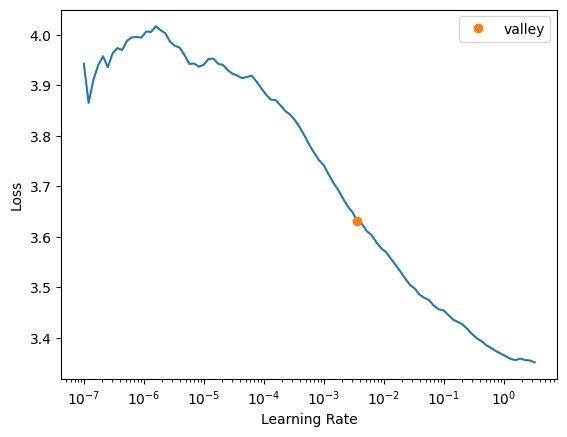

In [24]:
learn3.lr_find()

In [25]:
learn3.fit_one_cycle(12, 0.003, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.563954,2.718535,0.214286,01:43
1,2.201177,2.383388,0.302143,01:44
2,1.946963,2.136402,0.352857,01:44
3,1.757038,1.785742,0.451429,01:44
4,1.568005,1.843355,0.469286,01:44
5,1.496561,1.564314,0.507857,01:44
6,1.395554,1.516617,0.522143,01:44
7,1.309943,1.434652,0.554286,01:44
8,1.229020,1.340479,0.572857,01:44
9,1.109222,1.230210,0.607143,01:44


Como conclusión con esta arquitectura (sobre todo porque ya la llevamos al límite con 9.6 millones de parámetros). Da resultados aceptables para las limitaciones del problema: 64.5% de accuracy

Cambiando el enfoque de nuestros experimentos, vamos a crear bloques residuales. Con estos podemos crear redes más profundas con otro enfoque al que hicimos hasta ahorita. Por lo tanto, escribiremos las funciones que necesitamos para los bloques residuales

In [8]:
celu = nn.CELU(inplace=False)

def _get_bn_weight(A):
    if not isinstance(A, nn.Sequential): return 1
    if isinstance(A[-1], nn.BatchNorm2d): return A[-1].weight[None, :, None, None]
    return 1

class SmartAdd(nn.Module):
    def __init__(self, A, B):
        super().__init__()
        self.pathA = A
        self.pathB = B

    def forward(self, x):
        A, B = self.pathA, self.pathB

        a = _get_bn_weight(A)
        b = _get_bn_weight(B)

        divider = torch.sqrt(a*a + b*b) + 1e-6
        divider = divider.to(x)

        return (A(x) + B(x))/divider

@delegates(conv2d)
def cba(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p = 0., init='relu', **kwargs):
    layers = []
    
    layers += [conv2d(ni, no, init=init, bias=(not bn), **kwargs)]
    
    if bn:
        layers += [nn.BatchNorm2d(no)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    if activation: layers += [act_fn]

    if p > 0: layers += [nn.Dropout2d(p)]

    return layers

@delegates(conv2d)
def acb(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p = 0., init='relu', **kwargs):
    layers = []
    
    if activation: layers += [act_fn]
    
    layers += [conv2d(ni, no, init=init, bias=(not bn), **kwargs)]
    
    if bn:
        layers += [nn.BatchNorm2d(no)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    if p > 0: layers += [nn.Dropout2d(p)]

    return layers

def residual_builder(res_func, ni, no=None, s=1, use_pool=False, pre_activate=True, pre_act=celu, post_bn=True, **kwargs):
    if no is None: no = ni

    k = 3 if s == 1 else 4

    pool = identity
    if use_pool or s == 2 or no != ni:
        pool = conv2d(ni, no, k=k, s=s, init='avg')
        pre_activate = True
        post_bn = True

    layers = []

    if pre_activate: layers += [pre_act]
    if post_bn: layers += [nn.BatchNorm2d(ni)]

    residual = res_func(ni=ni, no=no, k=k, s=s, **kwargs)

    if not pre_activate: residual = [pre_act, *residual]    

    residual = nn.Sequential(*residual)
    rblock = SmartAdd(pool, residual)
    layers += [rblock]

    return nn.Sequential(*layers)

@delegates(residual_builder)
def ResBlock(ni, no=None, bottle=None, g=1, **kwargs):
    def _normal_residual(ni, no, bottle, k, s, g):
        if bottle is None: bottle = ni // 2
        return nn.Sequential(*cba(ni, bottle, g=g, activation=False),
                             *acb(bottle, no, k=k, s=s, g=g, bn_init_zero=True))
    
    return residual_builder(_normal_residual, ni, no, bottle=bottle, g=g, **kwargs)

Hagamos entonces un modelo con resblocks

In [29]:
model4 = nn.Sequential(
    ResBlock(3, 128, s=2),
    ResBlock(128, 256, s=2),
    ResBlock(256, 256, s=2),
    ResBlock(256, 512, s=2),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(512, data.c)
)

In [30]:
num_params(model4)

6196599

In [31]:
learn4 = fv.Learner(data,
                    model4,
                    opt_func=fv.ranger,
                    metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.005248074419796467)

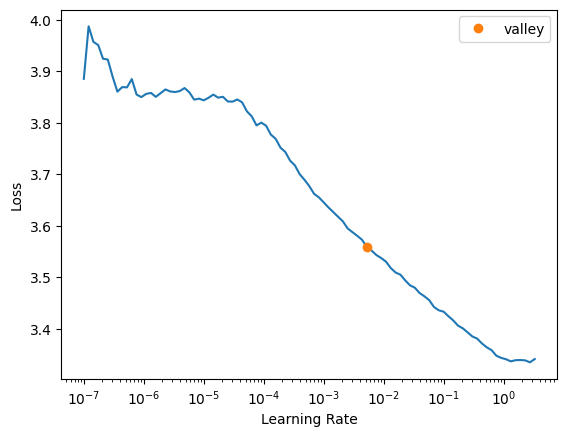

In [32]:
learn4.lr_find()

In [33]:
learn4.fit_one_cycle(12, 0.001, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.768714,2.661754,0.232143,02:03
1,2.448209,2.383507,0.322143,02:04
2,2.235858,2.222176,0.370714,02:04
3,2.099550,2.085617,0.402143,02:04
4,1.929076,1.977565,0.422143,02:04
5,1.841850,1.816340,0.457857,02:04
6,1.782367,1.777295,0.457857,02:04
7,1.718275,1.842345,0.452857,02:04
8,1.648252,1.706649,0.478571,02:04
9,1.549033,1.592804,0.500714,02:04


Como podemos ver la arquitectura no resultó tan diferente a la anterior. Tal vez con más épocas podría mejorar, pero teniendo nuestro límite de 12 entonces será mejor buscar mejorar la arquitectura. Sobre todo que mejore más entre época y época. Justo pensando en eso, la siguiente arquitectura se basa en las ideas de las Resnet

In [42]:
model5 = nn.Sequential(
    conv2d(3, 64, k=2, s=2),
    nn.MaxPool2d(kernel_size=3),
    ResBlock(64, 64),
    ResBlock(64, 128),
    ResBlock(128, 128, s=2),
    ResBlock(128, 256),
    ResBlock(256, 256, s=2),
    ResBlock(256, 512),         
    ResBlock(512, 256, s=2),    # Esta capa debería tener 512 en no, pero las bajamos por el límite de parámetros
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(256, data.c)
)

In [43]:
num_params(model5)

9423508

In [46]:
learn5 = fv.Learner(data, model5, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

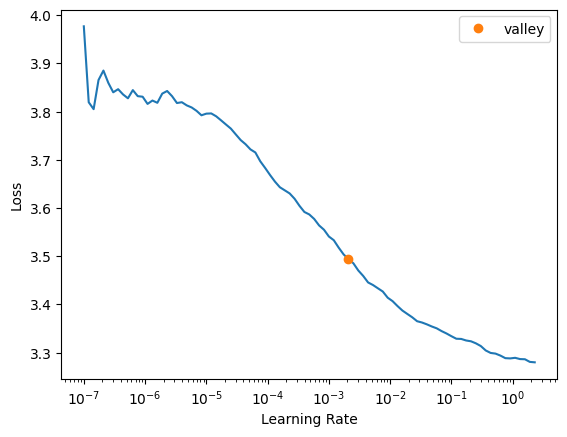

In [47]:
learn5.lr_find()

In [48]:
learn5.fit_one_cycle(12, 0.002, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.454740,2.379140,0.283571,00:39
1,2.135097,2.314477,0.333571,00:39
2,1.934653,2.065088,0.380714,00:39
3,1.728695,1.842817,0.428571,00:39
4,1.607715,1.816999,0.445000,00:39
5,1.520131,1.750880,0.467857,00:39
6,1.422629,1.902936,0.440714,00:39
7,1.358418,1.490137,0.518571,00:39
8,1.257164,1.686172,0.472857,00:39
9,1.146298,1.240768,0.600000,00:39


Como vemos nos quedamos muy cerca de alcanzar nuestro 64.5%. Lo que se alcanza a ver con los resblocks es que tardan mucho en entrenar y hay ciclos de unas 3 épocas en las que se estanca el entrenamiento. Si bien, en producción esto no sería problema (se dan más épocas y listo), para nuestro reto sí es un problema.

Ahora intentemos con una arquitectura similar pero mantiendo iguales el número de convoluciones

In [53]:
model6 = nn.Sequential(
    ResBlock(3, 256, s=2),
    ResBlock(256),
    ResBlock(256, s=2),
    ResBlock(256),
    ResBlock(256, s=2),
    ResBlock(256),
    ResBlock(256, s=2),
    ResBlock(256),
    ResBlock(256, s=2),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(256, data.c)
)

In [54]:
num_params(model6)

9866103

In [56]:
learn6 = fv.Learner(data, model6, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.007585775572806597)

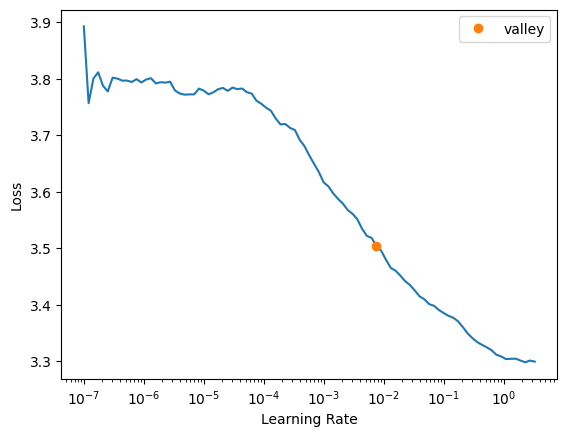

In [57]:
learn6.lr_find()

In [58]:
learn6.fit_one_cycle(12, 0.008, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.565291,2.434906,0.290000,05:06
1,2.134392,2.065816,0.373571,05:07
2,1.832710,1.921064,0.415000,05:06
3,1.651522,1.939539,0.419286,05:07
4,1.519505,1.701428,0.461429,05:07
5,1.409068,1.781319,0.447143,05:06
6,1.362091,1.559615,0.505000,05:06
7,1.304478,1.530079,0.530000,05:07
8,1.252256,1.408810,0.545714,05:06
9,1.113047,1.271780,0.592143,05:07


Los 3 modelos que hemos hecho con resblock lo que tienen en común es que se toman varias épocas para comenzar a mejorar. Aun con buenos resultados, son más tardados y no logran superar el 65% o incluso llegar al 70%

Por lo tanto, ahora comenzarmos con experimentos mezclando tipos de bloques diferentes y modificando detalles de las capas

In [9]:
@delegates(conv2d)
def abc(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p = 0., **kwargs):
    layers = []
    
    if activation: layers += [act_fn]
    if p > 0: layers += [nn.Dropout2d(p)]

    if bn:
        layers += [nn.BatchNorm2d(ni)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    layers += [conv2d(ni, no, bias=(not bn), **kwargs)]

    return layers

@delegates(abc)
def abc_block(ni,no,**kwargs):
    return nn.Sequential(*abc(ni,no,**kwargs))

class Stair(nn.Module):
    """groups should be an integer, or 'full' or 'mid' or a list of no//steps - 1 integers"""
    def __init__(self, ni, no=None, steps=4, k=3, s=1, groups = 1, act_fn=default_act):
        super().__init__()
        if no is None: no = ni
        
        if fv.is_listy(groups): steps = len(groups)+1
        p = steps
        
        assert(ni%p == 0 and no%p==0)
        t = no//p
        
        if type(groups) == int: groups = [groups]*(p-1)
        
        gg = groups
        if gg in ['full', 'mid']: groups = [p-i for i in range(1,p)]
        if gg == 'mid':
            groups = [(g if g%2==1 else g//2) for g in groups]
                
        assert(len(groups) == p-1)
        #print("groups = ", groups)
        self.t = t
        
        modules = [conv2d(ni,no,k=k,s=s)]
        modules += [abc_block((p-i)*t,(p-i)*t,act_fn=act_fn,g=g,init='avg') for i,g in zip(range(1,p),groups)]
        self.convs = nn.ModuleList(modules)
    
    def forward(self, x):
        t, convs = self.t, self.convs
        
        out = []
        
        for c in convs:
            #print(f"{i}: {c[1].in_channels}->{c[1].out_channels}, and x.shape={x.shape}")
            x = c(x)
            out.append(x[:,:t])
            x = x[:,t:]
            
        return torch.cat(out,dim=1)
    
@delegates(residual_builder)
def ResStairBlock(ni, no=None, bottle=None, steps=4, groups = 1, **kwargs):
    def _stair_residual(ni,no,bottle,k,s,steps,groups):
        if bottle is None: bottle = ni//2
        return nn.Sequential(Stair(ni, bottle, k=k, s=s, steps=steps, groups=groups),
                             *acb(bottle, no, k=1, s=1, bn_init_zero=True))
    
    return residual_builder(_stair_residual, ni, no, bottle=bottle, steps=steps, groups=groups, **kwargs)

@delegates(conv2d)
def acb(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p = 0., init='relu', **kwargs):
    layers = []
    
    if activation: layers += [act_fn]
    
    layers += [conv2d(ni, no, init=init, bias=(not bn), **kwargs)]
    
    if bn:
        layers += [nn.BatchNorm2d(no)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    if p > 0: layers += [nn.Dropout2d(p)]

    return layers

@delegates(acb)
def acb_block(ni,no,**kwargs):
    return nn.Sequential(*acb(ni,no,**kwargs))

class Cascade(nn.Module):
    def __init__(self,nf,steps,act_fn=default_act):
        super().__init__()
        assert(nf%steps == 0)
        t = nf//steps
        
        self.t = t
        
        modules = [acb_block(t,t,act_fn=act_fn) for _ in range(steps-1)]
        self.convs = nn.ModuleList(modules)
    
    def forward(self, x):
        t, convs = self.t, self.convs
        
        p = torch.split(x,t,dim=1)
        out = [p[0]]
        prev = 0.
        for conv, z in zip(convs, p[1:]):
            prev = conv(prev+z)
            out.append(prev)
        return torch.cat(out,dim=1)

@delegates(residual_builder)
def Res2Block(ni, no=None, bottle=None, g=1, **kwargs):
    def _cascade_residual(ni,no,bottle,k,s,g):
        if bottle is None: bottle = ni//2
        return nn.Sequential(*acb(ni, bottle, k=k, s=s, activation=False),
                             Cascade(bottle, steps=g),
                             *acb(bottle, no, k=1, s=1, bn_init_zero=True))
    
    return residual_builder(_cascade_residual, ni, no, bottle=bottle, g=g, **kwargs)
    

Nuestro siguiente modelo nos queda

In [60]:
model7 = nn.Sequential(
    *bca(3, 64, k=2, s=2, act_fn=nn.LeakyReLU(1/16, inplace=False)),
    *cba(64, 64),
    ResStairBlock(64, steps=4, groups=2),
    Res2Block(64),
    ResBlock(64, s=2),
    ResStairBlock(64, steps=4, groups=2),
    Res2Block(64),
    ResBlock(64, s=2),
    ResStairBlock(64, steps=4, groups=2),
    Res2Block(64),
    ResBlock(64, s=2),
    Res2Block(64),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(64, data.c)
)

In [61]:
num_params(model7)

548890

In [62]:
learn7 = fv.Learner(data, model7, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.009120108559727669)

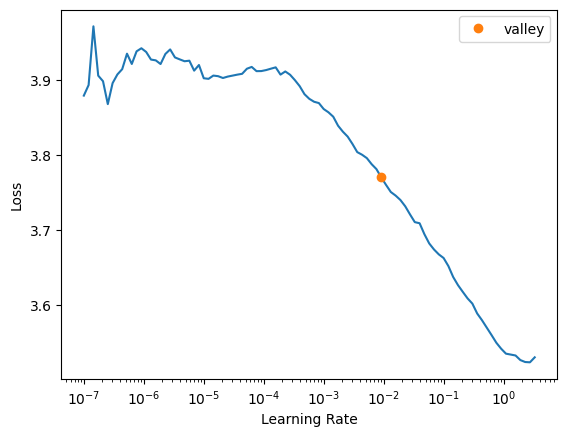

In [63]:
learn7.lr_find()

In [64]:
learn7.fit_one_cycle(12, 0.02, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.588849,2.479677,0.273571,02:03
1,2.192587,2.157476,0.351429,02:05
2,1.978699,1.879815,0.422857,02:05
3,1.807492,1.875769,0.440000,02:05
4,1.702593,1.765344,0.448571,02:05
5,1.648915,1.696795,0.485000,02:05
6,1.569445,1.736274,0.459286,02:05
7,1.530138,1.514709,0.513571,02:05
8,1.488420,1.606824,0.507857,02:05
9,1.372540,1.574166,0.503571,02:06


Como podemos ver, nuevamente nos quedamos en el 60%. Para las restricciones que tenemos es un resultado aceptable. Lo que es curioso es que los bloques residuales no logren superar las arquitecturas con simples convoluciones con batch norm.

Hagamos igualmente algunos experimentos más antes de declarar el modelo ganador

In [34]:
model8 = nn.Sequential(
    *bca(3, 64, k=2, s=2, act_fn=nn.LeakyReLU(1/16, inplace=False)),
    ResBlock(64),
    Res2Block(64),
    *bca(64, 128, k=2, s=2, act_fn=nn.LeakyReLU(1/16, inplace=False)),
    ResBlock(128),
    *bca(128, 256, k=2, s=2, act_fn=nn.LeakyReLU(1/16, inplace=False)),
    ResBlock(256),
    Res2Block(256),
    *bca(256, 512, k=2, s=2, act_fn=nn.LeakyReLU(1/16, inplace=False)),
    ResBlock(512),
    Res2Block(512),
    *bca(512, 512, k=2, s=2, act_fn=nn.LeakyReLU(1/16, inplace=False)),
    ResBlock(512),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(512, data.c)
)

In [35]:
num_params(model8)

8916954

In [36]:
learn8 = fv.Learner(data, model8, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.019054606556892395)

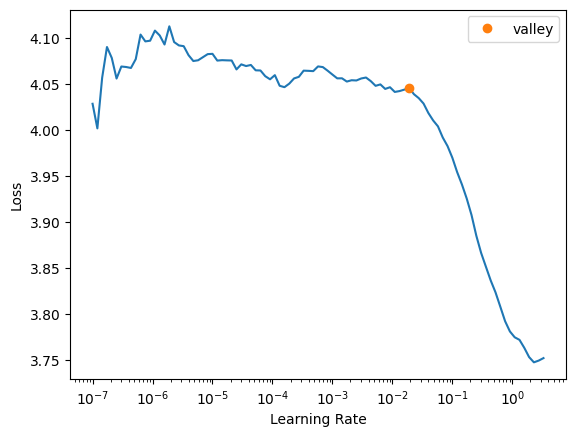

In [37]:
learn8.lr_find()

In [38]:
learn8.fit_one_cycle(12, 0.15, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.584028,4.511062,0.096429,01:22
1,2.381668,2.878016,0.227143,01:22
2,2.324172,2.762628,0.236429,01:21
3,2.263577,2.885992,0.225000,01:23
4,2.184321,2.605744,0.258571,01:22
5,2.142541,2.478413,0.270000,01:21
6,2.153946,2.223749,0.331429,01:22
7,2.118607,2.443515,0.292857,01:20
8,2.071211,2.731143,0.250714,01:22
9,2.030249,1.981355,0.395714,01:21


Tal vez con más épocas hubiera alcanzado mejores métricas

In [39]:
model9 = nn.Sequential(
    *bca(3, 64, k=2, s=2),
    ResBlock(64),
    *bca(64, 128, s=2),
    ResBlock(128),
    *bca(128, 256, s=2),
    ResBlock(256),
    *bca(256, 256, s=2),
    ResBlock(256),
    *bca(256, 256, s=2),
    ResBlock(256),
    ResBlock(256),
    ResBlock(256),
    *bca(256, 256),
    *bca(256, 256),
    *bca(256, 256),
    ResBlock(256),
    ResBlock(256),
    ResBlock(256),
    *bca(256, 256),
    *bca(256, 256),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(256, data.c)
)

In [40]:
num_params(model9)

9423514

In [41]:
learn9 = fv.Learner(data, model9, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.05754399299621582)

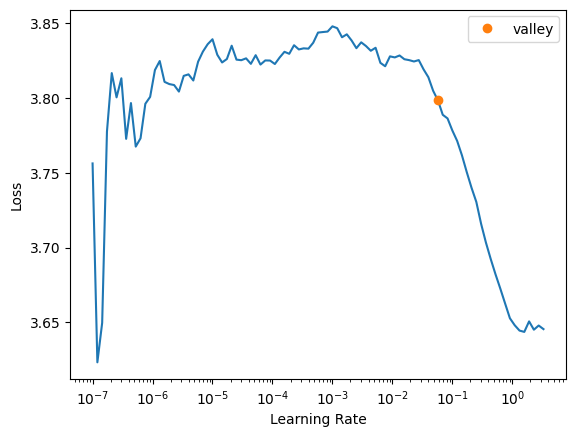

In [42]:
learn9.lr_find()

In [43]:
learn9.fit_one_cycle(12, 0.05, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.764727,3.030225,0.142143,01:10
1,2.583967,3.562657,0.182143,01:10
2,2.492523,2.912680,0.200714,01:10
3,2.403711,2.628855,0.222857,01:08
4,2.281807,2.513651,0.268571,01:10
5,2.333005,2.476476,0.260714,01:07
6,2.269212,2.520676,0.256429,01:07
7,2.215525,2.422598,0.276429,01:08
8,2.184207,2.196311,0.332857,01:09
9,2.164209,2.141623,0.345714,01:08


Como podemos ver, el aprendizaje es muy lento entre cada época.

Por lo tanto, vamos a hacer un último intento sin los resblock y sus variantes para intentar alcanzar el 70%, con base en la arquitectura que mejor nos funcionó

In [17]:
model10 = nn.Sequential(
    *bca(3, 128, k=2, s=2),
    *cba(128, 256),
    *bca(256,256,k=2,s=2),
    *cba(256,512),
    *bca(512,512,k=2,s=2),
    *cba(512,512),
    *bca(512,512,k=2,s=2),
    *cba(512,512),
    *bca(512,512,k=2,s=2),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(512, data.c)
)

In [18]:
num_params(model10)

9624154

In [19]:
learn10 = fv.Learner(data, model10, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.005248074419796467)

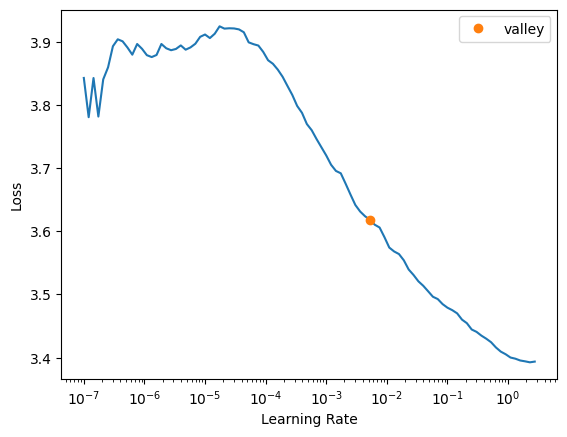

In [20]:
learn10.lr_find()

In [21]:
learn10.fit_one_cycle(12, 0.0008, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.408148,2.540354,0.278571,01:46
1,2.098246,2.182281,0.335714,01:46
2,1.896020,2.230173,0.351429,01:46
3,1.756649,1.927307,0.407143,01:46
4,1.648019,1.690492,0.486429,01:46
5,1.540702,1.632295,0.503571,01:46
6,1.470825,1.586552,0.532857,01:45
7,1.408379,1.804516,0.453571,01:45
8,1.343698,1.368400,0.585000,01:45
9,1.255057,1.313700,0.597857,01:45


Como podemos ver justo alcanzó el 64.5% que ya teníamos como mejor resultado. Lo único que mejoró esta arquitectura es la velocidad en la ejecución de cada época. Por lo tanto, este modelo (modelo 10) es el ganador.